In [1]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import tqdm

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
video_data = pd.read_csv('/content/video_df.csv') #Data was scraped - will add a link to my scraping and data cleaning Notebook
video_data = video_data.drop(['Unnamed: 0', 'favouriteCount'], axis=1)
video_df = video_data.copy(deep=True)

In [5]:
video_df['channelTitle'].unique() #These are the channels I follow :)

array(['How to Rip', 'Nathan Florence', 'Nic Von Rupp', 'Barefoot Surf',
       'Kai Lenny', 'Surf Strength Coach', 'Ombe Surf', 'Rip Curl',
       'Surfline', 'Red Bull Surfing', 'Kale Brock'], dtype=object)

In [6]:
# Extract data for LDA
titles = []

for title in video_df['title']:
  titles.append(title)
titles[:10]

['Surfing Will Change Your Life For The Better, In Ways You Have Never Imagined',
 'Surfing + Corporate Development = The Perfect Combination',
 'Using Surf Therapy To Help Frontline Workers Thrive | Aussie Frontline',
 'Surfer Escapes Into Nature',
 'Surfer Improves Their Pop Up x100 In One Surf',
 'Party Waves Are The Best Waves!',
 'Progress At An All Time Rate In Here',
 'Wave Pools Are A Surfers Greatest Cheat Code',
 'Special Session Under The Stars',
 'How To Surf From A Beginner To Intermediate In FIVE Days']

#**Step 1: Data Cleaning and Preprocessing**

In [7]:
%%time
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.87 ms


In [9]:
new_stop_words = ['surf', 'surfer', 'surfing'] #add words that don't contribute much meaning to the analysis
stop_words = stop_words + new_stop_words

print(len(stop_words))

182


In [10]:
def normalize_corpus(titles):
    norm_titles = []
    for title in tqdm.tqdm(titles):
        title = title.lower()
        title_tokens = [token.strip() for token in wtk.tokenize(title)]
        title_tokens = [wnl.lemmatize(token) for token in title_tokens if not token.isnumeric()]
        title_tokens = [token for token in title_tokens if len(token) > 1]
        title_tokens = [token for token in title_tokens if token not in stop_words]
        title_tokens = list(filter(None, title_tokens))
        norm_titles.append(title_tokens)

    return norm_titles

norm_titles = normalize_corpus(titles)
print(len(norm_titles))

100%|██████████| 8821/8821 [00:01<00:00, 4418.16it/s]

8821


In [11]:
norm_titles[:10]

[['change', 'life', 'better', 'way', 'never', 'imagined'],
 ['corporate', 'development', 'perfect', 'combination'],
 ['using',
  'therapy',
  'help',
  'frontline',
  'worker',
  'thrive',
  'aussie',
  'frontline'],
 ['escape', 'nature'],
 ['improves', 'pop', 'x100', 'one'],
 ['party', 'wave', 'best', 'wave'],
 ['progress', 'time', 'rate'],
 ['wave', 'pool', 'greatest', 'cheat', 'code'],
 ['special', 'session', 'star'],
 ['beginner', 'intermediate', 'five', 'day']]

In [12]:
#Check to see if any titles disappeared with the Stopword Removal
def check1(ori_list, new_list):
  if len(titles) == len(norm_titles):
    print('We\'r all set!')
  else:
    print('NO!')

check1(titles, norm_titles)

We'r all set!


Creating bigrams and Bag of Words

In [13]:
import gensim
gensim.__version__

'4.3.2'

In [14]:
bigram = gensim.models.Phrases(norm_titles, min_count=20, threshold=20)
bigram_model = gensim.models.phrases.Phraser(bigram)

In [15]:
norm_corpus_bigrams = bigram_model[norm_titles]
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)

In [16]:
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'better'), (1, 'change'), (2, 'imagined'), (3, 'life'), (4, 'never'), (5, 'way'), (6, 'combination'), (7, 'corporate'), (8, 'development'), (9, 'perfect'), (10, 'aussie'), (11, 'frontline'), (12, 'help'), (13, 'therapy'), (14, 'thrive')]
Total Vocabulary Size: 5670


In [17]:
dictionary.filter_extremes(no_below=0.02, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 5670


In [18]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]

In [19]:
print('Total number of video titles:', len(bow_corpus))

Total number of video titles: 8821


In [22]:
print('Average Youtube title length: ', sum(len(i) for i in bow_corpus)/len(bow_corpus))

Average Youtube title length:  5.218115859879832


#**Step 3: LDA - Tuning the Number of Topics**

Note that it really helps to already have a sense of the variation of videos (contextual knowledge)

In [23]:
def topic_model_coherence_generator(corpus, texts, dictionary,
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):

    models = []
    coherence_scores = []

    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                   id2word=dictionary, chunksize=895,
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=topic_nums,
                                   passes=20, eval_every=None)

        cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus,
                                                                     texts=texts, dictionary=dictionary,
                                                                    coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()

        coherence_scores.append(coherence_score)
        models.append(lda_model)

    return models, coherence_scores

In [24]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=40, step=1, cpus=4)

100%|██████████| 39/39 [14:43<00:00, 22.66s/it]


In [25]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 41, 1),
                             'Coherence Score': np.round(coherence_scores, 3)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
26,28,0.639
28,30,0.637
25,27,0.636
32,34,0.635
37,39,0.634
23,25,0.634
35,37,0.632
29,31,0.631
22,24,0.631
19,21,0.630


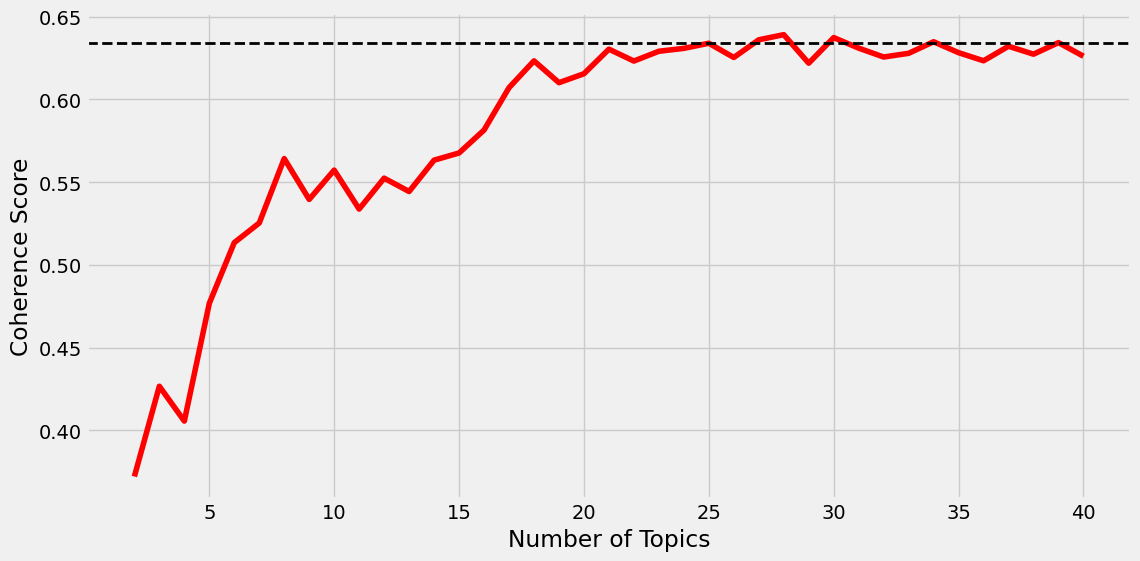

In [26]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 41, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.634, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [34]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 28].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

28

In [35]:
%%time
TOTAL_TOPICS = 28
best_lda_model = gensim.models.LdaModel(corpus=bow_corpus,
                                   id2word=dictionary, chunksize=len(bow_corpus),
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS,
                                   passes=20, eval_every=None)

CPU times: user 27.6 s, sys: 313 ms, total: 27.9 s
Wall time: 28 s


In [36]:
topics = [[(term, round(wt, 3))
               for term, wt in best_lda_model.show_topic(n, topn=10)]
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['wave', 'session', 'kelly_slater', 'winter', 'new', 'indonesia', 'ever', 'paddle', 'surfline', 'preview']

Topic #2:
['wave', 'world', 'back', 'contest', 'insane', 'tour', 'day', 'small', 'swell', 'caroline']

Topic #3:
['pipeline', 'gopro_angle', 'two', 'france', 'ho', 'derek', '6th', 'rocky_point', 'episode', 'matsuoka']

Topic #4:
['january', 'pipeline', 'wave', 'episode', 'angle', 'red_bull', 'day', 'burrow', 'forecast', 'eli_olson']

Topic #5:
['session', 'kai_lenny', 'barrel', 'jaw', 'kai', 'swell', 'surfline_tv', 'super', 'tahiti', 'kalani']

Topic #6:
['like', 'wave', 'ocean', 'teahupoo', 'line', 'full', 'mexico', 'part', 'never', 'inside']

Topic #7:
['pipeline', 'dec', 'jan', 'angle', 'jamie_brien', 'wall', 'november', 'feb', 'koa_rothman', 'nov']

Topic #8:
['video', 'outlook', 'round_heat', 'southern_california', 'jordy_smith', 'wilson', 'chris', 'davidson', 'julian', 'workweek']

Topic #9:
['mirage', 'one', 'curl', 'rip', 'ultimate', 'made', 'boardshort', 'wave'

In [37]:
topics_df = pd.DataFrame([[term for term, wt in topic]
                              for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 11)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28
Term1,wave,wave,pipeline,january,session,like,pipeline,video,mirage,gabriel_medina,...,pipeline,rip,curl,ep,portugal,rip,live,round_heat,cam_rewind,wave
Term2,session,world,gopro_angle,pipeline,kai_lenny,wave,dec,outlook,one,round_heat,...,tube,curl,rip,wave,wave,curl,surfline,wipeout,wave,von_froth
Term3,kelly_slater,back,two,wave,barrel,ocean,jan,round_heat,curl,hobgood,...,anthony_walsh,padang,best,winter,season,pro,cam,turn,catch,nazare
Term4,winter,contest,france,episode,jaw,teahupoo,angle,southern_california,rip,matt_wilkinson,...,mason_ho,cup_padang,bomb,training,best,gromsearch,north_shore,parkinson,love,really
Term5,new,insane,ho,angle,kai,line,jamie_brien,jordy_smith,ultimate,power,...,feb,bali,wsl,exercise,lucas,final,replay,need,front,nazaré
Term6,indonesia,tour,derek,red_bull,swell,full,wall,wilson,made,ross,...,jan_10th,wave,final,workout,champion,highlight,hawaii,durbidge,day,big
Term7,ever,day,6th,day,surfline_tv,mexico,november,chris,boardshort,damien,...,makua_rothman,made,etapa,depth_podcast,chumbo,day,lower,surfboard,mick_fanning,xxl
Term8,paddle,small,rocky_point,burrow,super,part,feb,davidson,wave,backdoor,...,dec,everything,energy,stretch,rail,portugal,three,wave,left,session
Term9,surfline,swell,episode,forecast,tahiti,never,koa_rothman,julian,mick_fanning,thing,...,tip,wetsuits,indonesia,fitness,world,beach,fin,bethany_hamilton,perfect,october
Term10,preview,caroline,matsuoka,eli_olson,kalani,inside,nov,workweek,search,got,...,jan_11th,new,wakita,style,azores,search,session,best,first,swell


In [38]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

<ipython-input-38-2344564c35e3>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"wave, session, kelly_slater, winter, new, indonesia, ever, paddle, surfline, preview"
Topic2,"wave, world, back, contest, insane, tour, day, small, swell, caroline"
Topic3,"pipeline, gopro_angle, two, france, ho, derek, 6th, rocky_point, episode, matsuoka"
Topic4,"january, pipeline, wave, episode, angle, red_bull, day, burrow, forecast, eli_olson"
Topic5,"session, kai_lenny, barrel, jaw, kai, swell, surfline_tv, super, tahiti, kalani"
Topic6,"like, wave, ocean, teahupoo, line, full, mexico, part, never, inside"
Topic7,"pipeline, dec, jan, angle, jamie_brien, wall, november, feb, koa_rothman, nov"
Topic8,"video, outlook, round_heat, southern_california, jordy_smith, wilson, chris, davidson, julian, workweek"
Topic9,"mirage, one, curl, rip, ultimate, made, boardshort, wave, mick_fanning, search"
Topic10,"gabriel_medina, round_heat, hobgood, matt_wilkinson, power, ross, damien, backdoor, thing, got"


###**Conclusions:**###
Within this set of YouTube Channels related to surfing, the videos fall into several key categories:
*  Competition (Topics 2, 7 18, and 23)
*  Instructional / training videos (Topics 11 and 22)
*  Equipment / Gear review (Topics 9 and 14)
*  Fun videos

It is noteworthy that Pro Surfers and the location of the video play a huge role in the category, even if these individuals' channels are not scrapped.

Key locations where competitions also occur are:
* Nazare and other locations in Portugal
* Pipeline and locations in Hawaii
* Bali (Padang Padang, Uluwati)

While the LDA tuning exercise shows that there are 28 topics, these topics are likely to be more finegrained and fall into the categories I highlighted earlier.


